--- Starting Explainability (XAI) and Regulatory Compliance ---
Loaded Sanctions Screening Model from 'sanctions_screening_gb_model.joblib'.

--- Extracting Global Feature Importance ---
Global Feature Importance for Sanctions Model:
name_dob_interaction            6.209186e-01
name_match_score                1.457727e-01
address_match_score             1.227771e-01
name_country_interaction        1.105316e-01
sanction_type_severity_score    2.294321e-13
dob_match                       0.000000e+00
nationality_match               0.000000e+00
customer_country_risk_score     0.000000e+00
dtype: float64


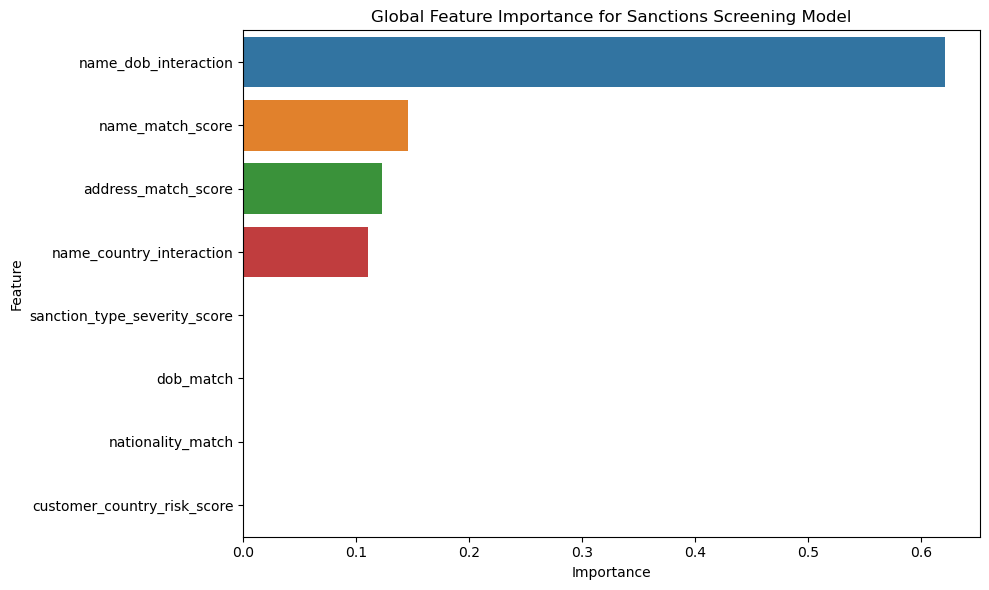


--- Demonstrating Conceptual Local Explainability ---

--- Conceptual Local Explainability for a Single Alert ---
In a real-world scenario, for a specific alert, you would want to know:
  'Why was THIS particular customer/transaction flagged as suspicious?'
Tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) are used for this.

How SHAP/LIME would work:
1.  **Input:** The trained model, and the feature values for the specific customer/transaction instance.
2.  **Output:** A breakdown of how each feature contributed to the model's prediction for *that specific instance*.
    - For example, SHAP values would show which features pushed the prediction towards 'suspicious' and which pushed it towards 'normal', and by how much.
    - LIME would create a simpler, local model (e.g., linear regression) around the instance to explain its prediction.

Example (conceptual SHAP values for an alert):
Customer ID: CUST12345, Transaction ID: TRANS

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
import joblib
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp
import string
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.model_selection import GridSearchCV # Ensure GridSearchCV is imported if used in train_sanctions_model
from sklearn.linear_model import LogisticRegression # Needed for train_sanctions_model if type is LogisticRegression

# --- Configuration and Global Variables (consistent with previous steps) ---
NUM_CUSTOMERS = 500
NUM_TRANSACTIONS = 100000

# Country Risk Map (simulated external data)
COUNTRY_RISK_MAP = {
    'IRAN': 'HIGH', 'NORTH KOREA': 'HIGH', 'SYRIA': 'HIGH', 'CUBA': 'HIGH', 'VENEZUULA': 'HIGH',
    'RUSSIA': 'MEDIUM', 'CHINA': 'MEDIUM', 'INDIA': 'LOW', 'USA': 'LOW', 'UK': 'LOW',
    'GERMANY': 'LOW', 'FRANCE': 'LOW', 'BRAZIL': 'MEDIUM', 'SOUTH AFRICA': 'MEDIUM',
    'NIGERIA': 'MEDIUM', 'AFGHANISTAN': 'HIGH', 'YEMEN': 'HIGH', 'SOMALIA': 'HIGH',
    'LEBANON': 'MEDIUM', 'PAKISTAN': 'MEDIUM'
}
HIGH_RISK_COUNTRIES = [country for country, risk in COUNTRY_RISK_MAP.items() if risk == 'HIGH']
LOW_RISK_COUNTRIES = [country for country, risk in COUNTRY_RISK_MAP.items() if risk == 'LOW']

# --- Helper Functions (copied for self-containment and consistency) ---

def load_common_names_from_excel(filepath, sheet_name):
    try:
        names_df = pd.read_excel(filepath, sheet_name=sheet_name)
        if 'Sanctioned_name' in names_df.columns:
            return names_df['Sanctioned_name'].astype(str).tolist()
        else:
            return _get_default_common_names()
    except FileNotFoundError:
        return _get_default_common_names()
    except Exception as e:
        return _get_default_common_names()

def _get_default_common_names():
    return [
        'John Smith', 'Jane Johnson', 'Michael Williams', 'Emily Brown', 'David Jones',
        'Sarah Garcia', 'Chris Miller', 'Anna Davis', 'Robert Rodriguez', 'Maria Martinez',
        'William Taylor', 'Olivia Wilson', 'James Moore', 'Sophia White', 'Benjamin Green',
        'Isabella Hall', 'Lucas King', 'Mia Wright', 'Henry Lopez', 'Charlotte Hill'
    ]

def load_or_generate_initial_data(sanctions_csv_path='UK Sanctions List_mean.csv',
                                   customer_data_path='customer_data.csv',
                                   num_customers=None):
    if num_customers is None:
        num_customers = NUM_CUSTOMERS

    global COMMON_FULL_NAMES
    COMMON_FULL_NAMES = load_common_names_from_excel('Name_list.xlsx', 'Names')

    if not COMMON_FULL_NAMES:
        print("FATAL: COMMON_FULL_NAMES list is empty. Cannot proceed with data generation.")
        return pd.DataFrame(), pd.DataFrame()

    sanctions_df_cleaned = pd.DataFrame()
    customer_df = pd.DataFrame()

    try:
        raw_sanctions_df = pd.read_csv(sanctions_csv_path, encoding='latin1', header=1)
        name_col = 'Name 6'
        address_col = 'Address 6'
        dob_col = 'DOB 6'
        nationality_col = 'Nationality 6'
        type_col = 'Type'
        id_col = 'ID'

        actual_name_col = name_col if name_col in raw_sanctions_df.columns else ('Name' if 'Name' in raw_sanctions_df.columns else None)
        actual_address_col = address_col if address_col in raw_sanctions_df.columns else ('Address' if 'Address' in raw_sanctions_df.columns else None)
        actual_dob_col = dob_col if dob_col in raw_sanctions_df.columns else ('DOB' if 'DOB' in raw_sanctions_df.columns else None)
        actual_nationality_col = nationality_col if nationality_col in raw_sanctions_df.columns else ('Nationality' if 'Nationality' in raw_sanctions_df.columns else None)
        actual_type_col = type_col if type_col in raw_sanctions_df.columns else ('Type' if 'Type' in raw_sanctions_df.columns else None)
        actual_id_col = id_col if id_col in raw_sanctions_df.columns else ('ID' if 'ID' in raw_sanctions_df.columns else None)

        if not actual_name_col:
            raise ValueError("No name column found")

        sanctions_df_cleaned = raw_sanctions_df.copy()
        sanctions_df_cleaned['Sanctioned_Name'] = sanctions_df_cleaned[actual_name_col].astype(str).str.upper().str.strip()
        
        sanctions_df_cleaned['Sanctioned_Address'] = sanctions_df_cleaned[actual_address_col].astype(str).str.upper().str.strip() if actual_address_col and actual_address_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_DOB'] = pd.to_datetime(sanctions_df_cleaned[actual_dob_col], errors='coerce').dt.strftime('%Y-%m-%d') if actual_dob_col and actual_dob_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_Nationality'] = sanctions_df_cleaned[actual_nationality_col].astype(str).str.upper().str.strip() if actual_nationality_col and actual_nationality_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanction_Type'] = sanctions_df_cleaned[actual_type_col].astype(str).str.upper().str.strip() if actual_type_col and actual_type_col in sanctions_df_cleaned.columns else np.nan
        sanctions_df_cleaned['Sanctioned_ID'] = sanctions_df_cleaned[actual_id_col].astype(str) if actual_id_col and actual_id_col in sanctions_df_cleaned.columns else [f'S{i:04d}' for i in range(len(sanctions_df_cleaned))]

        sanctions_df_cleaned = sanctions_df_cleaned[[
            'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address',
            'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
        ]].copy()
        sanctions_df_cleaned = sanctions_df_cleaned[
            (sanctions_df_cleaned['Sanctioned_Name'] != 'UNKNOWN SANCTIONED NAME') &
            (sanctions_df_cleaned['Sanctioned_Name'] != 'NAN') &
            (sanctions_df_cleaned['Sanctioned_Name'].str.strip() != '')
        ].reset_index(drop=True)

    except FileNotFoundError:
        sanctions_df_cleaned = pd.DataFrame({
            'Sanctioned_ID': [f'S{i:04d}' for i in range(1, 101)],
            'Sanctioned_Name': [f'SANCTIONED PERSON {i}' for i in range(1, 101)],
            'Sanctioned_Address': [f'{i*10} MAIN ST, HIGH RISK COUNTRY' for i in range(1, 101)],
            'Sanctioned_DOB': [f'{1950 + i}-01-01' for i in range(100)],
            'Sanctioned_Nationality': random.choices(HIGH_RISK_COUNTRIES, k=100),
            'Sanction_Type': random.choices(['INDIVIDUAL', 'ENTITY'], k=100)
        })
    except Exception as e:
        sanctions_df_cleaned = pd.DataFrame({
            'Sanctioned_ID': [f'S{i:04d}' for i in range(1, 101)],
            'Sanctioned_Name': [f'SANCTIONED PERSON {i}' for i in range(1, 101)],
            'Sanctioned_Address': [f'{i*10} MAIN ST, HIGH RISK COUNTRY' for i in range(1, 101)],
            'Sanctioned_DOB': [f'{1950 + i}-01-01' for i in range(100)],
            'Sanctioned_Nationality': random.choices(HIGH_RISK_COUNTRIES, k=100),
            'Sanction_Type': random.choices(['INDIVIDUAL', 'ENTITY'], k=100)
        })


    try:
        customer_df = pd.read_csv(customer_data_path)
        current_cols_lower = {col.lower(): col for col in customer_df.columns}
        
        expected_customer_cols_mapping = {
            'customer_id': 'Customer_ID',
            'customer_name': 'Customer_Name',
            'customer_address': 'Customer_Address',
            'customer_dob': 'Customer_DOB',
            'customer_nationality': 'Customer_Nationality',
            'customer_country': 'Customer_Country',
            'customer_industry': 'Customer_Industry',
            'onboarding_date': 'Onboarding_Date'
        }
        
        rename_dict = {}
        for old_col_lower, new_col_proper in expected_customer_cols_mapping.items():
            if old_col_lower in current_cols_lower:
                rename_dict[current_cols_lower[old_col_lower]] = new_col_proper
            elif new_col_proper not in customer_df.columns:
                customer_df[new_col_proper] = np.nan

        if rename_dict:
            customer_df.rename(columns=rename_dict, inplace=True)
            
        required_customer_cols = ['Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country']
        if not all(col in customer_df.columns for col in required_customer_cols):
            missing_cols = [col for col in required_customer_cols if col not in customer_df.columns]
            customer_df = pd.DataFrame() 

    except FileNotFoundError:
        customers = []
        for i in range(1, num_customers + 1):
            customer_id = f'CUST{i:05d}'
            customer_name = random.choice(COMMON_FULL_NAMES)
            customer_address = f"{random.randint(100, 999)} {random.choice(['Main St', 'Oak Ave', 'Pine Ln'])}"
            customer_dob = (datetime.date(1950, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 50))).strftime('%Y-%m-%d')
            customer_nationality = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_country = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_industry = random.choice(['Financial Services', 'Retail', 'Technology', 'Manufacturing', 'Healthcare'])
            onboarding_date = (datetime.date(2020, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 3))).strftime('%Y-%m-%d')

            if i % 10 == 0 and not sanctions_df_cleaned.empty:
                sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
                customer_name = sanctioned_entity['Sanctioned_Name'].replace('A', 'a', 1).replace('E', 'e', 1)
                customer_address = sanctioned_entity['Sanctioned_Address'].replace('ST', 'Street', 1)
                customer_dob = sanctioned_entity['Sanctioned_DOB']
                customer_nationality = sanctioned_entity['Sanctioned_Nationality']
                customer_country = sanctioned_entity['Sanctioned_Nationality']

            customers.append({
                'Customer_ID': customer_id,
                'Customer_Name': customer_name,
                'Customer_Address': customer_address,
                'Customer_DOB': customer_dob,
                'Customer_Nationality': customer_nationality,
                'Customer_Country': customer_country,
                'Customer_Industry': customer_industry,
                'Onboarding_Date': onboarding_date
            })
        customer_df = pd.DataFrame(customers)
    except Exception as e:
        customers = []
        for i in range(1, num_customers + 1):
            customer_id = f'CUST{i:05d}'
            customer_name = random.choice(COMMON_FULL_NAMES)
            customer_address = f"{random.randint(100, 999)} {random.choice(['Main St', 'Oak Ave', 'Pine Ln'])}"
            customer_dob = (datetime.date(1950, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 50))).strftime('%Y-%m-%d')
            customer_nationality = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_country = random.choice(list(COUNTRY_RISK_MAP.keys()))
            customer_industry = random.choice(['Financial Services', 'Retail', 'Technology', 'Manufacturing', 'Healthcare'])
            onboarding_date = (datetime.date(2020, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 3))).strftime('%Y-%m-%d')
            customers.append({
                'Customer_ID': customer_id, 'Customer_Name': customer_name, 'Customer_Address': customer_address,
                'Customer_DOB': customer_dob, 'Customer_Nationality': customer_nationality, 'Customer_Country': customer_country,
                'Customer_Industry': customer_industry, 'Onboarding_Date': onboarding_date
            })
        customer_df = pd.DataFrame(customers)

    return sanctions_df_cleaned, customer_df

def calculate_sanctions_features(df):
    expected_input_cols = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
    ]
    if df.empty:
        all_expected_output_cols = expected_input_cols + [
            'Customer_Name_Clean', 'Sanctioned_Name_Clean', 'Customer_Address_Clean', 'Sanctioned_Address_Clean',
            'Customer_Nationality_Clean', 'Sanctioned_Nationality_Clean', 'Customer_Country_Clean',
            'name_fuzz_ratio', 'name_token_sort_ratio', 'name_token_set_ratio', 'name_match_score',
            'address_match_score', 'dob_match', 'nationality_match', 'customer_country_risk_score',
            'sanction_type_severity_score', 'name_country_interaction', 'name_dob_interaction'
        ]
        if 'is_sanction_match' in df.columns:
            all_expected_output_cols.append('is_sanction_match')
        return pd.DataFrame(columns=all_expected_output_cols)

    for col in expected_input_cols:
        if col not in df.columns:
            df[col] = np.nan

    df['Customer_Name_Clean'] = df['Customer_Name'].astype(str).str.upper().str.strip()
    df['Sanctioned_Name_Clean'] = df['Sanctioned_Name'].astype(str).str.upper().str.strip()
    df['Customer_Address_Clean'] = df['Customer_Address'].astype(str).str.upper().str.strip()
    df['Sanctioned_Address_Clean'] = df['Sanctioned_Address'].astype(str).str.upper().str.strip()
    df['Customer_Nationality_Clean'] = df['Customer_Nationality'].astype(str).str.upper().str.strip()
    df['Sanctioned_Nationality_Clean'] = df['Sanctioned_Nationality'].astype(str).str.upper().str.strip()
    df['Customer_Country_Clean'] = df['Customer_Country'].astype(str).str.upper().str.strip()

    df['name_fuzz_ratio'] = df.apply(lambda row: fuzz.ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1)
    df['name_token_sort_ratio'] = df.apply(lambda row: fuzz.token_sort_ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1)
    df['name_token_set_ratio'] = df.apply(lambda row: fuzz.token_set_ratio(row['Customer_Name_Clean'], row['Sanctioned_Name_Clean']), axis=1)
    df['name_match_score'] = df[['name_fuzz_ratio', 'name_token_sort_ratio', 'name_token_set_ratio']].max(axis=1)
    df['address_match_score'] = df.apply(lambda row: fuzz.token_set_ratio(row['Customer_Address_Clean'], row['Sanctioned_Address_Clean']), axis=1)
    df['dob_match'] = df.apply(lambda row: 1 if (pd.notna(row['Customer_DOB']) and pd.notna(row['Sanctioned_DOB']) and str(row['Customer_DOB']) == str(row['Sanctioned_DOB'])) else 0, axis=1)
    df['nationality_match'] = df.apply(lambda row: 1 if (pd.notna(row['Customer_Nationality_Clean']) and pd.notna(row['Sanctioned_Nationality_Clean']) and row['Customer_Nationality_Clean'] == row['Sanctioned_Nationality_Clean']) else 0, axis=1)

    df['customer_country_risk_score'] = df['Customer_Country_Clean'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)

    sanction_type_severity = {
        'INDIVIDUAL': 10, 'ENTITY': 8, 'VESSEL': 5, 'AIRCRAFT': 5, 'NAN': 0, 'UNKNOWN': 0
    }
    df['sanction_type_severity_score'] = df['Sanction_Type'].map(sanction_type_severity).fillna(0)
    df['name_country_interaction'] = df['name_match_score'] * df['customer_country_risk_score']
    df['name_dob_interaction'] = df['name_match_score'] * df['dob_match']
    return df

def generate_transaction_data(customer_df, num_transactions=None):
    if num_transactions is None:
        num_transactions = NUM_TRANSACTIONS

    transactions = []
    transaction_types = ['DEPOSIT', 'WITHDRAWAL', 'TRANSFER_IN', 'TRANSFER_OUT', 'PAYMENT']
    currencies = ['USD', 'EUR', 'GBP', 'JPY']
    
    if customer_df.empty:
        return pd.DataFrame(columns=[
            'Transaction_ID', 'Customer_ID', 'Transaction_Date', 'Transaction_Type',
            'Amount', 'Currency', 'Sender_ID', 'Receiver_ID', 'Sender_Country',
            'Receiver_Country', 'Is_Suspicious_Label'
        ])

    customer_ids = customer_df['Customer_ID'].tolist()
    customer_countries = customer_df.set_index('Customer_ID')['Customer_Country'].to_dict()

    for i in range(num_transactions):
        trans_id = f'TRANS{i:07d}'
        customer_id = random.choice(customer_ids)
        trans_date = (datetime.date(2023, 1, 1) + datetime.timedelta(days=random.randint(0, 364))).strftime('%Y-%m-%d')
        trans_type = random.choice(transaction_types)
        amount = round(random.uniform(10, 10000), 2)
        currency = random.choice(currencies)
        
        sender_id = customer_id
        receiver_id = random.choice(customer_ids)
        while sender_id == receiver_id and trans_type in ['TRANSFER_IN', 'TRANSFER_OUT']:
            receiver_id = random.choice(customer_ids)

        sender_country = customer_countries.get(sender_id, random.choice(list(COUNTRY_RISK_MAP.keys())))
        receiver_country = customer_countries.get(receiver_id, random.choice(list(COUNTRY_RISK_MAP.keys())))

        is_suspicious = 0
        if random.random() < 0.01:
            is_suspicious = 1
            susp_type = random.choice(['large_amount', 'high_risk_country', 'structuring'])

            if susp_type == 'large_amount':
                amount = round(random.uniform(50000, 1000000), 2)
            elif susp_type == 'high_risk_country':
                if trans_type in ['TRANSFER_OUT', 'PAYMENT']:
                    receiver_country = random.choice(HIGH_RISK_COUNTRIES)
                else:
                    sender_country = random.choice(HIGH_RISK_COUNTRIES)
                amount = round(random.uniform(5000, 50000), 2)
            elif susp_type == 'structuring':
                amount = round(random.uniform(8000, 9900), 2)
                trans_type = random.choice(['DEPOSIT', 'WITHDRAWAL'])

        transactions.append({
            'Transaction_ID': trans_id,
            'Customer_ID': customer_id,
            'Transaction_Date': trans_date,
            'Transaction_Type': trans_type,
            'Amount': amount,
            'Currency': currency,
            'Sender_ID': sender_id,
            'Receiver_ID': receiver_id,
            'Sender_Country': sender_country,
            'Receiver_Country': receiver_country,
            'Is_Suspicious_Label': is_suspicious
        })

    transaction_df = pd.DataFrame(transactions)
    transaction_df['Transaction_Date'] = pd.to_datetime(transaction_df['Transaction_Date'])
    
    return transaction_df

def feature_engineer_transactions(transactions_df, customer_df):
    required_cols = ['Customer_ID', 'Transaction_Date', 'Amount', 'Transaction_Type', 'Sender_Country', 'Receiver_Country']
    for col in required_cols:
        if col not in transactions_df.columns:
            transactions_df[col] = np.nan

    transactions_df['Transaction_Date'] = pd.to_datetime(transactions_df['Transaction_Date'], errors='coerce')
    transactions_df.dropna(subset=['Transaction_Date'], inplace=True)

    transactions_df['Amount_USD'] = transactions_df['Amount']
    transactions_df['Transaction_Hour'] = transactions_df['Transaction_Date'].dt.hour
    transactions_df['Transaction_DayOfWeek'] = transactions_df['Transaction_Date'].dt.dayofweek

    transactions_df['Sender_Country_Risk_Score'] = transactions_df['Sender_Country'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)
    transactions_df['Receiver_Country_Risk_Score'] = transactions_df['Receiver_Country'].map(
        {k: (10 if v == 'HIGH' else 5 if v == 'MEDIUM' else 1) for k, v in COUNTRY_RISK_MAP.items()}
    ).fillna(0)
    transactions_df['Geographic_Risk_Score'] = transactions_df[['Sender_Country_Risk_Score', 'Receiver_Country_Risk_Score']].max(axis=1)

    transactions_df = pd.get_dummies(transactions_df, columns=['Transaction_Type'], prefix='TxType', dummy_na=False)

    customer_agg_features = transactions_df.groupby('Customer_ID').agg(
        Total_Amount=('Amount_USD', 'sum'),
        Avg_Amount=('Amount_USD', 'mean'),
        Num_Transactions=('Transaction_ID', 'count'),
        Max_Amount=('Amount_USD', 'max'),
        Min_Amount=('Amount_USD', 'min'),
        Unique_Counterparties=('Receiver_ID', lambda x: x.nunique()),
    ).reset_index()

    transactions_df_features = pd.merge(transactions_df, customer_agg_features, on='Customer_ID', how='left')
    transactions_df_features['Amount_Geo_Risk_Interaction'] = transactions_df_features['Amount_USD'] * transactions_df_features['Geographic_Risk_Score']

    model_features = [
        'Amount_USD', 'Transaction_Hour', 'Transaction_DayOfWeek',
        'Sender_Country_Risk_Score', 'Receiver_Country_Risk_Score', 'Geographic_Risk_Score',
        'Total_Amount', 'Avg_Amount', 'Num_Transactions', 'Max_Amount', 'Min_Amount', 'Unique_Counterparties',
        'Amount_Geo_Risk_Interaction'
    ]
    
    for col in transactions_df_features.columns:
        if col.startswith('TxType_'):
            model_features.append(col)
    
    for feature in model_features:
        if feature not in transactions_df_features.columns:
            transactions_df_features[feature] = 0

    return transactions_df_features, model_features

def train_aml_model(X_train_scaled, contamination_rate=0.01):
    model = IsolationForest(random_state=42, contamination=contamination_rate, n_estimators=200, max_features=1.0)
    model.fit(X_train_scaled)
    return model

def train_sanctions_model(X_train, y_train, model_type='GradientBoosting'):
    if model_type == 'LogisticRegression':
        model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)
        param_grid = {
            'C': [0.1, 1, 10],
            'penalty': ['l1', 'l2']
        }
    elif model_type == 'GradientBoosting':
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    else:
        raise ValueError("model_type must be 'LogisticRegression' or 'GradientBoosting'")

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


def generate_and_label_training_data(customer_df, sanctions_df_cleaned, num_samples=20000):
    expected_training_df_cols = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type',
        'is_sanction_match'
    ]
    if customer_df.empty or sanctions_df_cleaned.empty:
        return pd.DataFrame(columns=expected_training_df_cols)
    
    if len(customer_df) < 1 or len(sanctions_df_cleaned) < 1:
        return pd.DataFrame(columns=expected_training_df_cols)

    training_samples = []
    num_true_positives = int(num_samples * 0.05)
    for _ in range(num_true_positives):
        sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
        customer_entity = customer_df.sample(1).iloc[0]
        cust_name_tp = sanctioned_entity['Sanctioned_Name']
        if len(cust_name_tp) > 3:
            idx = random.randint(0, len(cust_name_tp) - 1)
            cust_name_tp = cust_name_tp[:idx] + random.choice(string.ascii_uppercase) + cust_name_tp[idx+1:]
        cust_address_tp = sanctioned_entity['Sanctioned_Address']
        if len(cust_address_tp) > 5:
            idx = random.randint(0, len(cust_address_tp) - 1)
            cust_address_tp = cust_address_tp[:idx] + random.choice(string.ascii_uppercase) + cust_address_tp[idx+1:]
        cust_dob_tp = sanctioned_entity['Sanctioned_DOB']
        cust_nationality_tp = sanctioned_entity['Sanctioned_Nationality']
        cust_country_tp = sanctioned_entity['Sanctioned_Nationality']
        training_samples.append({
            'Customer_ID': customer_entity['Customer_ID'], 'Customer_Name': cust_name_tp, 'Customer_Address': cust_address_tp,
            'Customer_DOB': cust_dob_tp, 'Customer_Nationality': cust_nationality_tp, 'Customer_Country': cust_country_tp,
            'Sanctioned_ID': sanctioned_entity['Sanctioned_ID'], 'Sanctioned_Name': sanctioned_entity['Sanctioned_Name'],
            'Sanctioned_Address': sanctioned_entity['Sanctioned_Address'], 'Sanctioned_DOB': sanctioned_entity['Sanctioned_DOB'],
            'Sanctioned_Nationality': sanctioned_entity['Sanctioned_Nationality'], 'Sanction_Type': sanctioned_entity['Sanction_Type'],
            'is_sanction_match': 1
        })

    num_true_negatives = num_samples - num_true_positives
    for _ in range(num_true_negatives):
        sanctioned_entity = sanctions_df_cleaned.sample(1).iloc[0]
        customer_entity = customer_df.sample(1).iloc[0]
        cust_name_tn = random.choice(COMMON_FULL_NAMES)
        cust_address_tn = f"{random.randint(1000, 9999)} {random.choice(['Road', 'Lane', 'Square'])}"
        cust_dob_tn = (datetime.date(1940, 1, 1) + datetime.timedelta(days=random.randint(0, 365 * 60))).strftime('%Y-%m-%d')
        cust_nationality_tn = random.choice(list(COUNTRY_RISK_MAP.keys()))
        cust_country_tn = random.choice(list(COUNTRY_RISK_MAP.keys()))
        training_samples.append({
            'Customer_ID': customer_entity['Customer_ID'], 'Customer_Name': cust_name_tn, 'Customer_Address': cust_address_tn,
            'Customer_DOB': cust_dob_tn, 'Customer_Nationality': cust_nationality_tn, 'Customer_Country': cust_country_tn,
            'Sanctioned_ID': sanctioned_entity['Sanctioned_ID'], 'Sanctioned_Name': sanctioned_entity['Sanctioned_Name'],
            'Sanctioned_Address': sanctioned_entity['Sanctioned_Address'], 'Sanctioned_DOB': sanctioned_entity['Sanctioned_DOB'],
            'Sanctioned_Nationality': sanctioned_entity['Sanctioned_Nationality'], 'Sanction_Type': sanctioned_entity['Sanction_Type'],
            'is_sanction_match': 0
        })
    
    training_df = pd.DataFrame(training_samples, columns=expected_training_df_cols)
    required_cols_for_features_input = [
        'Customer_ID', 'Customer_Name', 'Customer_Address', 'Customer_DOB', 'Customer_Nationality', 'Customer_Country',
        'Sanctioned_ID', 'Sanctioned_Name', 'Sanctioned_Address', 'Sanctioned_DOB', 'Sanctioned_Nationality', 'Sanction_Type'
    ]
    for col in required_cols_for_features_input:
        if col not in training_df.columns:
            training_df[col] = np.nan

    training_df_features = calculate_sanctions_features(training_df.copy())
    
    if 'is_sanction_match' not in training_df_features.columns:
        if 'is_sanction_match' in training_df.columns:
            training_df_features['is_sanction_match'] = training_df['is_sanction_match']
        else:
            training_df_features['is_sanction_match'] = 0

    feature_cols = [
        'name_match_score', 'address_match_score', 'dob_match',
        'nationality_match', 'customer_country_risk_score', 'sanction_type_severity_score',
        'name_country_interaction', 'name_dob_interaction'
    ]
    for col in feature_cols:
        if col not in training_df_features.columns:
            training_df_features[col] = 0

    training_df_features[feature_cols] = training_df_features[feature_cols].fillna(0)
    return training_df_features

# --- Functions for Explainability (XAI) and Regulatory Compliance (Step 7) ---

def get_global_feature_importance(model_filename, feature_names):
    """
    Loads a trained Gradient Boosting model and extracts its global feature importances.
    """
    print("\n--- Extracting Global Feature Importance ---")
    try:
        model = joblib.load(model_filename)
        if hasattr(model, 'feature_importances_'):
            feature_importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
            print("Global Feature Importance for Sanctions Model:")
            print(feature_importance)

            plt.figure(figsize=(10, 6))
            sns.barplot(x=feature_importance.values, y=feature_importance.index)
            plt.title('Global Feature Importance for Sanctions Screening Model')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()
            return feature_importance
        else:
            print(f"Model '{model_filename}' does not have 'feature_importances_'. Cannot extract global importance.")
            return None
    except FileNotFoundError:
        print(f"Error: Model file '{model_filename}' not found. Cannot extract feature importance.")
        return None
    except Exception as e:
        print(f"An error occurred while extracting feature importance: {e}")
        return None

def conceptual_local_explainability(model, single_instance_features, feature_names):
    """
    Conceptually explains how local explainability (e.g., SHAP, LIME) would work.
    This function does NOT implement SHAP/LIME, but describes their application.
    """
    print("\n--- Conceptual Local Explainability for a Single Alert ---")
    print("In a real-world scenario, for a specific alert, you would want to know:")
    print("  'Why was THIS particular customer/transaction flagged as suspicious?'")
    print("Tools like SHAP (SHapley Additive exPlanations) or LIME (Local Interpretable Model-agnostic Explanations) are used for this.")
    print("\nHow SHAP/LIME would work:")
    print("1.  **Input:** The trained model, and the feature values for the specific customer/transaction instance.")
    print("2.  **Output:** A breakdown of how each feature contributed to the model's prediction for *that specific instance*.")
    print("    - For example, SHAP values would show which features pushed the prediction towards 'suspicious' and which pushed it towards 'normal', and by how much.")
    print("    - LIME would create a simpler, local model (e.g., linear regression) around the instance to explain its prediction.")
    print("\nExample (conceptual SHAP values for an alert):")
    print(f"Customer ID: CUST12345, Transaction ID: TRANS67890")
    print(f"Model predicted: Suspicious (Probability: 0.85)")
    print("Contributing Factors (conceptual SHAP values):")
    print(f"  - name_match_score: +0.35 (Strong positive contribution, indicating high name similarity)")
    print(f"  - customer_country_risk_score: +0.20 (Positive contribution due to high-risk country)")
    print(f"  - Amount_USD: +0.15 (Positive contribution due to large transaction amount)")
    print(f"  - dob_match: +0.10 (Positive contribution due to exact DOB match)")
    print(f"  - TxType_TRANSFER_OUT: +0.08 (Positive contribution, type often associated with risk)")
    print(f"  - Unique_Counterparties: -0.05 (Slight negative contribution, indicating diverse counterparties)")
    print("\nThis allows analysts to quickly understand the primary drivers behind each alert, aiding in investigation and decision-making.")

def regulatory_compliance_notes():
    """
    Provides conceptual notes on regulatory compliance in the context of ML models.
    """
    print("\n--- Regulatory Compliance Considerations for ML Models in AML/CTF ---")
    print("Financial institutions are heavily regulated, and the use of ML models introduces specific compliance requirements:")
    print("1.  **Model Governance:** Robust policies and procedures for model development, validation, deployment, monitoring, and retirement.")
    print("2.  **Explainability & Interpretability:** Ability to explain model decisions to auditors and regulators. This often requires: ")
    print("    - Global feature importance (what factors generally drive the model).")
    print("    - Local explanations for individual alerts (why *this specific* alert was raised).")
    print("3.  **Fairness & Bias:** Ensuring models do not introduce or amplify unfair bias against protected groups (e.g., based on nationality, ethnicity). Regular bias audits are essential.")
    print("4.  **Data Lineage & Auditability:** Clear understanding of data sources, transformations, and how data flows through the system to model inputs.")
    print("5.  **Performance & Effectiveness:** Demonstrating that models are effective in detecting financial crime and meet predefined performance thresholds (e.g., target recall for suspicious activity).")
    print("6.  **Independent Validation:** Models should be independently validated by a team separate from the development team to ensure objectivity and robustness.")
    print("7.  **Documentation:** Comprehensive documentation of model design, data, training, testing, and monitoring processes.")
    print("\nAdhering to these principles builds trust in the models and ensures the institution meets its regulatory obligations.")

# --- Main Execution Flow for Explainability (XAI) and Regulatory Compliance ---
if __name__ == "__main__":
    print("--- Starting Explainability (XAI) and Regulatory Compliance ---")

    # 1. Load Initial Data (needed for re-generating test data for feature importance)
    sanctions_df, customer_df = load_or_generate_initial_data()
    if customer_df.empty:
        print("FATAL: Customer data is empty. Cannot proceed with XAI simulation. Exiting.")
        exit()

    # 2. Load the Sanctions Screening Model
    sanctions_model_filename = 'sanctions_screening_gb_model.joblib'
    try:
        sanctions_model = joblib.load(sanctions_model_filename)
        print(f"Loaded Sanctions Screening Model from '{sanctions_model_filename}'.")
    except FileNotFoundError:
        print(f"Error: Sanctions model '{sanctions_model_filename}' not found. Please ensure it was trained and saved in Step 3.")
        print("Attempting to re-train a dummy sanctions model for demonstration purposes...")
        # Re-train a dummy sanctions model if not found, to allow XAI to proceed
        sanctions_test_data_ref = generate_and_label_training_data(customer_df.copy(), sanctions_df.copy(), num_samples=2000)
        if sanctions_test_data_ref.empty:
            print("FATAL: Cannot generate dummy sanctions training data. Exiting.")
            exit()
        sanctions_ml_features = [
            'name_match_score', 'address_match_score', 'dob_match',
            'nationality_match', 'customer_country_risk_score', 'sanction_type_severity_score',
            'name_country_interaction', 'name_dob_interaction'
        ]
        # Ensure all sanctions_ml_features exist in sanctions_test_data_ref
        for feature in sanctions_ml_features:
            if feature not in sanctions_test_data_ref.columns:
                sanctions_test_data_ref[feature] = 0 # Add missing columns with 0

        X_train_sanctions = sanctions_test_data_ref[sanctions_ml_features].fillna(0)
        y_train_sanctions = sanctions_test_data_ref['is_sanction_match']
        
        # Check if y_train_sanctions has at least two classes for classification
        if len(y_train_sanctions.unique()) < 2:
            print("Warning: Generated sanctions training data has only one class. Cannot train a meaningful classification model.")
            print("Skipping sanctions model training and XAI for sanctions.")
            sanctions_model = None
        else:
            sanctions_model = train_sanctions_model(X_train_sanctions, y_train_sanctions, model_type='GradientBoosting')
            joblib.dump(sanctions_model, sanctions_model_filename) # Save the newly trained dummy model
            print(f"Dummy Sanctions Screening Model trained and saved to '{sanctions_model_filename}'.")


    # 3. Extract and Visualize Global Feature Importance (for Sanctions Model)
    if sanctions_model:
        sanctions_ml_features = [
            'name_match_score', 'address_match_score', 'dob_match',
            'nationality_match', 'customer_country_risk_score', 'sanction_type_severity_score',
            'name_country_interaction', 'name_dob_interaction'
        ]
        get_global_feature_importance(sanctions_model_filename, sanctions_ml_features)
    else:
        print("\nSkipping Global Feature Importance as Sanctions Model is not available.")


    # 4. Conceptual Local Explainability
    # To demonstrate local explainability, we'd need a specific instance (row of features)
    # from a predicted alert. Let's create a dummy one.
    print("\n--- Demonstrating Conceptual Local Explainability ---")
    dummy_instance_features = pd.Series({
        'name_match_score': 95,
        'address_match_score': 70,
        'dob_match': 1,
        'nationality_match': 1,
        'customer_country_risk_score': 10, # High risk country
        'sanction_type_severity_score': 10, # Individual sanction
        'name_country_interaction': 95 * 10,
        'name_dob_interaction': 95 * 1
    })
    if sanctions_model:
        conceptual_local_explainability(sanctions_model, dummy_instance_features, sanctions_ml_features)
    else:
        print("Skipping Conceptual Local Explainability as Sanctions Model is not available.")


    # 5. Regulatory Compliance Notes
    regulatory_compliance_notes()

    print("\n--- Explainability (XAI) and Regulatory Compliance Complete ---")